In [20]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

# Main configs

In [21]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000

# Load the data the old way


In [22]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [23]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, includeDirection = False , TrimAt= 15 ):
    if includeDirection:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1)  for x in inp ][:15])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ][:15])

In [24]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [25]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    print( len(y_data), len(cleans) )
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y, ret_y_s

In [26]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = {}
y_train = {}

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
        x_data = json.load(f)
        
#     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
#         y_data = json.load(f)

#     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
#         x_data = json.load(f)
  
    if len( y_data ) != len(x_data) :
        print( pick )
        
    
    x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , Mapping=Mapper )
    
    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    test_files = sorted(glob.glob( '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' ))
    print( "found files : " , len(test_files) )
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/', fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join('../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/', fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)


        x_test.append(t_x)
        y_test.append(t_y)
        y_test_service.append(t_z)
            
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
58958 57867
loading from test files
found files :  4
32069 32069
19968 19968
9109 9109
6404 6404


(57867, 4)

# Evaluate Mittigation Techniques

## Packet Padding

In [ ]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

In [ ]:
# days =[7,4,2,2]
# t_sum =0
# d_sum = 0
# import math
# for ii in range(len(x_test)):

#     p = x_test[ii]
#     for i in p : 
#         t_sum += math.ceil(np.sum(i) / 2000)
#         d_sum+= np.sum( i )
# total_fixed  =  t_sum* 2000 / 15

# print ( total_fixed , d_sum, d_sum-t_sum*2000)

## Packet Insertion

In [ ]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

# sets the classes 

In [27]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'), (1, 'activity'), (2, 'battery'), (3, 'button'), (4, 'colorTemperature'), (5, 'contact'), (6, 'level'), (7, 'lock'), (8, 'motion'), (9, 'ping'), (10, 'status'), (11, 'switch'), (12, 'temperature'), (13, 'threeAxis'), (14, 'unknown'), (15, 'water')]


[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'ping'),
 (10, 'status'),
 (11, 'switch'),
 (12, 'temperature'),
 (13, 'threeAxis'),
 (14, 'unknown'),
 (15, 'water')]

## This section controls wheather the unknown packets are removed or not, this should be tested with and without removed unknowns 

In [ ]:
def is_clean_event( inp, return_clean= True  ):
    if return_clean:
        return  'no_logs' not in inp and 'lock-unlocked' not in inp and 'on/off-XXX' not in inp and 'raw-XXX' not in inp and 'read_attr_-_raw-XXX' not in inp
    else:
        return  'lock-locked' in inp or 'lock-unlocked'  in inp or 'on/off-XXX' in inp or  'raw-XXX' in inp  or 'read_attr_-_raw-XXX' in inp 
    
def is_clean_service( inp, return_clean= True  ):
    
    if return_clean:
        return  'no_logs' not in inp and 'unknown' not in inp and 'read_attr_-_raw' not in inp #and 'ping' not in inp 
    else:
        return  'no_logs' in inp or  'unknown' in inp  or 'read_attr_-_raw' in inp #or 'ping' in inp 
#     return  "contact-open" not in inp and 'contact-closed' not in inp

In [ ]:
toKeep = [ i for i in range(len(y_train)) if is_clean_event( y_train[i]) ] if Mapper=='SE' else [ i for i in range(len(y_train)) if is_clean_service( y_train[i]) ]
x_train= [ x_train[i] for i in toKeep ]
y_train= [ y_train[i] for i in toKeep ]


In [ ]:
for j in range(len(x_test)):
    toChange= [ i for i in range(len(y_test[j])) if is_clean_service( y_test[j][i], False) ]
    y_test[j] = [ (y_test[j][i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test[j])) ]

In [ ]:
# classes.remove('read_attr_-_raw-XXX')
# classes.remove('on/off-XXX')
# classes.remove('raw-XXX')
# classes.remove('lock-unlocked')
# classes.remove('lock-locked')


# classes.remove('read_attr_-_raw')
# classes.remove('on/off')
# classes.remove('raw')
classes.remove('unknown')

# classes.remove('lock')
# # classes.remove('lock')


# classes.remove('switch-on')



service_classes= ["","",""]


## ===== end of unknown packet control=====

In [28]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,classes=None, twoD= False ):
#  y data 
# """
# this functino is in charge of preprocessing the records , the sourc e json contains a lot of extra stuff, this function tailors
# the data and it fixes their lenghth
# """
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            if y in classes:
                temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

# Model Evaluation Methods

In [29]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
#     F= 2.0*( prec* recall )/ (prec+recall)
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    return acc, recall, prec, F

def acc_match( true, pred ):
    """
    returns exact mathc accuracy
    """
 
    return (len( [ x  for x  in  [np.sum(np.abs( true[i]- pred[i] )) for i in range(len(true))] if x  == 0]))*1.0 / len(true)


# def acc_none_zero ( true, pred ):
    

def acc_match_wierd( true, pred ):
    """
    returns exact mathc accuracy
    """
    level = 6 
    switch = 11
    threeAxis=13
    accel = 0 
    status=10
    contact=5
    
    counter  = 0 
    for i in range( len (true) ):
        if np.sum(np.abs( true[i]- pred[i] ))==0 :
            counter+=1
        else : 
            t_rec = np.array(list( pred[i]))
            
            if true[i][level]==1 and true[i][switch]==1 and t_rec[level]==1 :
                t_rec[switch]=1
            
            if true[i][threeAxis]==1 and true[i][accel]==1 and t_rec[threeAxis]==1:
                t_rec[accel] =1
            
            if true[i][status]==1 and true[i][contact]==1 and t_rec[status]==1:
                t_rec[contact]=1
#             print(t_rec , true[i])    
            if np.sum(np.abs( true[i]- t_rec ))==0 :
                counter+=1   
            
             
            
    
    return counter*1.0 / len(true)


def print_info(y_test, pred , classes , confidance=0.5 ):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s %16s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP/TN/FP/FN"))
    print( "------------------------------------------------------------------------" )
    
    for index in range(len(classes)):
        tp = conf[index][1][1]
        tn = conf[index][0][0]
        fp = conf[index][0][1] 
        fn = conf[index][1][0]
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %d/%d/%d/%d"  %
             (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index],
                  tp ,
                tn ,
                fp ,
                fn ))
    n_zeros_true = len([ x  for x  in  [np.sum(np.abs( y_test[i] )) for i in range(len(y_test))] if x  == 0]  )
    n_zeros_pred = len([ x  for x  in  [np.sum(np.abs( pred[i] )) for i in range(len(pred))] if x  == 0]  )
    
    accs = np.nan_to_num(accs)
    
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %d/%d/%d/%d"  %
             ("AVERAGES",
              np.average( accs, axis=0)[0],
              np.average( accs, axis=0)[1],
              np.average( accs, axis=0)[2],
              np.average( accs, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ( "Exact Match ACC : %.5f " % acc_match( y_test, pred )  )
#     print ( "Wierd Exact Match ACC : %.5f" % acc_wierd)
    print ( "Total Records : %d " % len(y_test)  )
    print ( "Total ZXeros in True : %d (%.3f)%%" % (n_zeros_true ,  n_zeros_true * 1.0/ len(y_test)  ))
    print ( "Total ZXeros in Test : %d (%.3f)%%" % (n_zeros_pred ,  n_zeros_pred * 1.0/ len(y_test)  ) )
    print ('=============================================================================')
    

In [30]:
def make_readable_results ( inp , classes , conffidance=True):
    ret = [] 
    inp =inp.astype(int)
    for xx in range(len(inp)) :
        u = inp[xx]
        temp = []
        for j in range(len(u)) : 
            if u[j] >0:
                temp.append(classes[j])
        ret.append(temp)
    return ret


def makeReadable( model , data, gt, path , classes, x, confidance=0.7):
    pred_temp = model.predict(data)
    print_info(gt, pred_temp, classes , confidance=confidance)
    print( len(classes ), len( pred_temp[0] ) )
    xcc= make_readable_results(pred_temp , classes)
    y_gt = make_readable_results( gt, classes )
    temp_dic = {} 
    for pick in range(len(xcc)): 
        temp_dic[ pick +1 ] =  { 'seq': str(data[pick]),
                               'pred': xcc[pick],
                                'true':y_gt[pick]
                               }   

    with open(path , 'w') as f:
        json.dump(temp_dic , f, indent=4)


# def makeReadable( model , data, gt, path , classes, confidance=0.7, x):
#     pred_temp = model.predict( data)
#     print_info(gt, pred_temp, classes , confidance=confidance)
#     xcc= make_readable_results( pred_temp , classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] = xcc[pick]  

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)

# Create the Model 

# Calcualte per class accuracy

# Random Forest baseline calc

In [ ]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
# x_random_forest_test,y_random_forest_test, _ = pre_process_raw( x_test[0], y_test[0] , dim_size, zero_pad=True, normalize=False, classes=classes)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes) for i in range(len(x_test)) ] 
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_random_forest_train, y_random_forest_train)




# print(clf.feature_importances_)

# print(clf.predict([[0, 0, 0, 0]]))
# from sklearn import metrics
# scores = cross_val_score(clf, x_random_forest_train, y_random_forest_train, cv=10, scoring='accuracy')

In [ ]:
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_tests[i][0])
    print_info( rf_tests[i][1], rf_pred, classes)

In [ ]:
# makeReadable( data=rf_tests[0][0], model=clf, classes=classes, confidance=0.7,gt=rf_tests[0][1], path='sk_home_out.json' )

In [ ]:
# print_info(y_random_forest_test, rf_pred, classes)

In [ ]:
# print_info(y_random_forest_test, rf_pred, classes)

In [ ]:
# print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

# LSTM 

In [ ]:
# cnts  = np.unique(np.array([ len(x) for x  in x_train ]), return_counts=True)
# # np.sort( cnts[1] )
# cnts

In [31]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=False, classes=service_classes) for i in range(len(x_test)) ] 



In [32]:
for i in range( len(lstm_tests) ):
    print( len( lstm_tests[i][0] ), len( lstm_tests_services[i][0] ) )

32069 32069
19968 19968
9109 9109
6404 6404


In [33]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests) ):
    lstm_tests[tt]= (lstm_tests[tt][0].reshape(len(lstm_tests[tt][0]),dim_size,1) , lstm_tests[tt][1],lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [34]:
np.sum(y_s_lstm_processed_train)

60562.0

In [35]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    


# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())

hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 15, 128)      512         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 15, 128)      512         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 15, 128)      0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv1d_9 (

Epoch 1/100
57867/57867 [==============================] - 7s 125us/step - loss: 45.3149 - f1_perRow: 0.0991 - f1_perClass: 0.2685 - acc: 0.3673
Epoch 2/100
57867/57867 [==============================] - 2s 36us/step - loss: 24.9812 - f1_perRow: 0.1479 - f1_perClass: 0.5986 - acc: 0.4668
Epoch 3/100
57867/57867 [==============================] - 2s 35us/step - loss: 22.5274 - f1_perRow: 0.1954 - f1_perClass: 0.6255 - acc: 0.4668
Epoch 4/100
57867/57867 [==============================] - 2s 35us/step - loss: 21.4959 - f1_perRow: 0.2246 - f1_perClass: 0.6300 - acc: 0.4668
Epoch 5/100
57867/57867 [==============================] - 2s 35us/step - loss: 20.6836 - f1_perRow: 0.2561 - f1_perClass: 0.6411 - acc: 0.4668
Epoch 6/100
57867/57867 [==============================] - 2s 36us/step - loss: 20.1946 - f1_perRow: 0.2781 - f1_perClass: 0.6454 - acc: 0.4668
Epoch 7/100
57867/57867 [==============================] - 2s 36us/step - loss: 19.8484 - f1_perRow: 0.2945 - f1_perClass: 0.6506 - acc

In [48]:
y_lstm_prossed_train[0]


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [45]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)







dens_out_3 = Dense( 128, activation='relu' )(dout_2)


# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=1000, batch_size=12500, shuffle=True, callbacks=callbacks_list)





NameError: name 'weights' is not defined

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )






out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)


dens_out_3 = Dense( 128, activation='relu' )(fl_out_cnn)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [42]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )







# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [ fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 15, 128)      512         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 15, 128)      512         conv1d_23[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 15, 128)      0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
dropout_24

57867/57867 [==============================] - 1s 23us/step - loss: 15.8029 - f1_perRow: 0.4410 - f1_perClass: 0.7181 - acc: 0.4714
Epoch 66/100
57867/57867 [==============================] - 1s 23us/step - loss: 15.6709 - f1_perRow: 0.4387 - f1_perClass: 0.7192 - acc: 0.4670
Epoch 67/100
57867/57867 [==============================] - 1s 23us/step - loss: 15.6630 - f1_perRow: 0.4429 - f1_perClass: 0.7181 - acc: 0.4671
Epoch 68/100
57867/57867 [==============================] - 1s 24us/step - loss: 15.7833 - f1_perRow: 0.4375 - f1_perClass: 0.7170 - acc: 0.4672
Epoch 69/100
57867/57867 [==============================] - 1s 23us/step - loss: 15.7421 - f1_perRow: 0.4370 - f1_perClass: 0.7150 - acc: 0.4684
Epoch 70/100
57867/57867 [==============================] - 1s 23us/step - loss: 15.6950 - f1_perRow: 0.4403 - f1_perClass: 0.7198 - acc: 0.4682
Epoch 71/100
57867/57867 [==============================] - 1s 23us/step - loss: 15.5313 - f1_perRow: 0.4511 - f1_perClass: 0.7185 - acc: 0.486

In [ ]:
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perClass ,
#     "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
#     "service_output": 20
}
 


model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=1e-6  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
# model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=16500, shuffle=True)


In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [ ]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

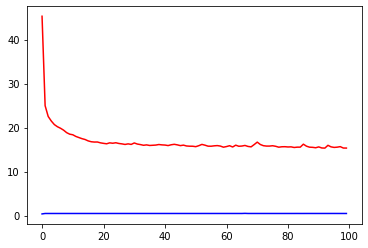

In [36]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [ ]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [43]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.5,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path=test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000      0.333     0.154     0.211         6 2/32052/11/4
                      activity     0.999      0.500     0.889     0.640        48 24/32018/3/24
                       battery     1.000        nan       nan       nan         0 0/32069/0/0
                        button     0.579      0.571     0.000     0.001         7 4/18550/13512/3
              colorTemperature     1.000        nan     0.000     0.000         0 0/32065/4/0
                       contact     0.998      0.628     0.576     0.601        78 49/31955/36/29
                         level     0.999      0.444     0.500     0.471        27 12/32030/12/15
                          lock     0.997      0.571     0.070     0.125        14 8/31949/106/6
                        motion     0.966      0.001     1.000


# ------------- do not go any further :) ------

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [ ]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [ ]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.43)

In [ ]:
# for i in [1] :
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)
    

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [ ]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [ ]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)